# =================== Assignment 3 ======================

## Amazon Fine Food Reviews Analysis and KNN Classification

​
The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>
​
Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 
​
Attribute Information:
​
1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review
​

#### Objective:
Given a Review plot and determine KNN to find out more accurate 'K' point to classify data and Analyse the words, If related to Positive class or Negative class.

In [1]:
# ============================== loading libraries ===========================================
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import string
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split

import re

import sqlite3


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
# =============================================================================================

C:\Users\Ghost\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
con = sqlite3.connect('database.sqlite') 
amzn = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)
print("Shape of Amzn Dataframe :",amzn.shape)
print("\n")
print("Head(2) of Amzn Dataframe")
print("**************************")
amzn.head(2)

Shape of Amzn Dataframe : (525814, 10)


Head(2) of Amzn Dataframe
**************************


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


**Function to impute the review to -1- "Positive" (Rating of 4 or 5) or -0- "Negative" (rating of 1 or 2).**

In [3]:
def part(data):
    if data > 3:
        return 1
    else:
        return 0

**Applying Function to Amazon['Score'] factor**

In [4]:
amzn['Score'] = amzn['Score'].map(part)

In [5]:
amzn.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


**Taking 1000-1000 of Positive and Negative observation out of 500k as Machine is Slow for further analysis**

In [6]:
#Positive = amzn[amzn['Score'] == 1].head(1000)
#Negative = amzn[amzn['Score'] == 0].head(1000)
#combined = [Positive,Negative]
#amazon = pd.concat(combined)
#amazon = sklearn.utils.shuffle(amazon)
print("Shape of Amazon Dataframe :",amzn.shape)

Shape of Amazon Dataframe : (525814, 10)


# Data Preprocessing

**Checking how many observations have Duplicated values in dataset with Variables['UserId','ProfileName','Score','Time']**

In [7]:
print(amzn.duplicated(subset=['UserId','ProfileName','Score','Time']).sum())

192811


**Dropping Duplicated values and keeping only first occuring observation in dataset**

In [8]:
amzn = amzn.drop_duplicates(subset=['UserId','ProfileName','Score','Time'], keep='first')

In [9]:
print(amzn.duplicated().sum())

0


**Cross checking for missing data in Dataset**

In [10]:
amzn.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

**The value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible, So Going to keep all the observations which have HelpfulnessNumerator is less than or Equal to HelpfulnessDenominator.**

In [11]:
amzn = amzn[amzn['HelpfulnessNumerator'] <= amzn['HelpfulnessDenominator']]

(333001, 10)
1    277625
0     55376
Name: Score, dtype: int64


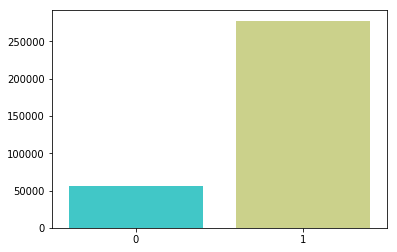

In [12]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(amzn.shape)

#How many positive and negative reviews are present in our dataset?
class_bal = amzn['Score'].value_counts()
print(class_bal)

#Plotting barplot for target variable to compare balance between them.
sns.barplot(class_bal.index, class_bal.values, palette="rainbow")

**Function which will**

1] Remove all html sets of sentences from reviews

2] Remove all punctuation present in reviews as are not necessary for analysis and modeling

In [13]:
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

**Code Working**

1] Remove HTMl tags

2] Split the reviews

3] Converting reviews to lower case

4] Removing Stop words

5] Storing of all words used to describe positive reviews and negative reviews.

In [14]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''


for sent in amzn['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower()))
                    filtered_sentence.append(s)
                    if (amzn['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(amzn['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = " ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i+=1

**Adding a column of CleanedText which displays the data after pre-processing of the review**

In [15]:
amzn['CleanedText'] = final_string
amzn = amzn.sort_values('Time')
print(amzn.head(2))

            Id   ProductId         UserId         ProfileName  \
138706  150524  0006641040  ACITT7DI6IDDL     shari zychinski   
138683  150501  0006641040  AJ46FKXOVC7NR  Nicholas A Mesiano   

        HelpfulnessNumerator  HelpfulnessDenominator  Score       Time  \
138706                     0                       0      1  939340800   
138683                     2                       2      1  940809600   

                                                  Summary  \
138706                          EVERY book is educational   
138683  This whole series is great way to spend time w...   

                                                     Text  \
138706  this witty little book makes my son laugh at l...   
138683  I can remember seeing the show when it aired o...   

                                              CleanedText  
138706  witti littl book make son laugh loud recit car...  
138683  rememb see show air televis year ago child sis...  


**Taking Sample of 5000 Observation after preprocess of data and after sorting all the data.**

##### Taking Sample of 5000 because Machine is Not responding if taking large sample of dataset or getting "Memory Error".

In [16]:
amazon = amzn.head(50000)
print(amazon.shape)

(50000, 11)


In [17]:
amazon.head(2)
from sklearn.metrics import accuracy_score

**Spliting data to train and test as 80-20 for further steps and analysis**

In [18]:
X_train, X_test, y_train, y_test = train_test_split(amazon['CleanedText'], amazon['Score'], test_size=0.2)

print("Text:  ",len(X_train), len(X_test), len(X_train) + len(X_test))
print("Score: ",len(y_train), len(y_test), len(y_train) + len(y_test))

Text:   40000 10000 50000
Score:  40000 10000 50000


# Functions to call again and again whenever needed

**Function takes Train and test data to find better K value with Less Error or With Better Accuracy**

In [19]:
from sklearn.model_selection import GridSearchCV

**Function for GridSearchCV and K optimal using different K so dont need to execute code again and again and when necessary can be called**

In [20]:
def best_K_train_test(X_train, y_train, X_test, y_test):
    for i in range(1,12,2):
        # instantiate learning model (k = 12)
        knn = KNeighborsClassifier(n_neighbors=i, algorithm= 'brute')

        # fitting the model on crossvalidation train
        knn.fit(X_train, y_train)
        
        # predict the response on the crossvalidation train
        pred = knn.predict(X_test)

        # evaluate CV accuracy
        acc = accuracy_score(y_test, pred, normalize=True) * float(100)
        print("=========================================")
        print('CV accuracy for k = %d is %d%%' % (i, acc))
        print("=========================================")
        

        
def Grid_CV(X_train, y_train): 
    params = [{'n_neighbors':[5,7,9,11]}]
    tuned_classifier = KNeighborsClassifier(algorithm= 'brute')
    grid_search = GridSearchCV(estimator=tuned_classifier, param_grid=params, scoring = 'f1', cv = 3)
    grid_search = grid_search.fit(X_train, y_train)
    print("Grid Search CV Best 'K' Parameter")        
    print("=================================")
    print(grid_search.best_params_)

**Function to  Plot K and Error based on Cross Validate of Train data to find optimal K for Model where Cross Validation Cv=3 and K=3,5,7,9,11**

In [21]:
def crossval_error_plot(X_train, y_train):
    
    # creating odd list of K for KNN
    neighbors = [3,5,7,9,11]

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm= 'brute')
        scores = cross_val_score(knn, X_train, y_train, cv=3, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)

    # plot misclassification error vs k 
    plt.plot(neighbors, MSE)

    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    print("CV Scores: ",cv_scores)

**Function to print Accuracy, Confusion Matrix based on Performance**

In [22]:
def fit_predict_performance_CM_CV(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    prediction = classifier.predict(X_test)
    
    cv_perfor = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=3)
    k_fold_performance = cv_perfor.mean()
    
    print("K-fold cross validation score of model for k = 3 is :")
    print(k_fold_performance * float(100))
    print("====================================")
    print("====================================")
    print()
    
    print("Correct Classified Data Point: ",accuracy_score(y_test, prediction, normalize=False))
    print()
    print("Correct % Classified Data Point: ",accuracy_score(y_test, prediction) * 100 ,"%")
    print("====================================")
    print()
    
    print("====== Confusion matrix ======= ")
    cm = confusion_matrix(y_test,prediction)
    print(cm)
    

    df_CM = pd.DataFrame(cm)
    print("Confusion Matrix")
    print("==================")
    print(df_CM)
    print("==================")
    fig = plt.figure()
    sns.heatmap(df_CM, annot=True, fmt="d")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

**Function takes train data to find best K value based on Cross validation on Train data**

**Storing Y values to "y_train" & "y_test" for further prediction and analysis**

In [23]:
y_train = y_train.values
y_test = y_test.values

# Bag Of Words(BoW), KNN

**Creating Bag of words using CountVectorizer() function and printing Shape of same and Unique words present in reviews**

In [24]:
#BoW
CV = CountVectorizer() #in scikit-learn
Bow_X_train = CV.fit_transform(X_train)
Bow_X_test = CV.transform(X_test)
print("Shape of BOW vectorizer: ",Bow_X_train.get_shape(), Bow_X_test.get_shape())
print("Number of unique words in 'Bow_X_train': ", Bow_X_train.get_shape()[1])
print("Number of unique words in 'Bow_X_test': ", Bow_X_test.get_shape()[1])

Shape of BOW vectorizer:  (40000, 24431) (10000, 24431)
Number of unique words in 'Bow_X_train':  24431
Number of unique words in 'Bow_X_test':  24431


**Calling classifier function with "Bow_X_train, y_train, Bow_X_test, y_test" for better K with Highest accuracy for BOW**

In [25]:
best_K_train_test(Bow_X_train, y_train, Bow_X_test, y_test)

CV accuracy for k = 1 is 84%
CV accuracy for k = 3 is 86%
CV accuracy for k = 5 is 87%
CV accuracy for k = 7 is 87%
CV accuracy for k = 9 is 87%
CV accuracy for k = 11 is 87%


In [148]:
Grid_CV(Bow_X_train, y_train)

Grid Search CV Best 'K' Parameter
{'n_neighbors': 11}



The optimal number of neighbors is 9.


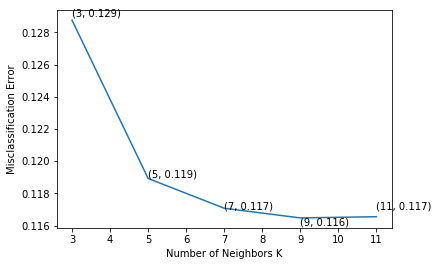

the misclassification error for each k value is :  [0.129 0.119 0.117 0.116 0.117]
CV Scores:  [0.8712503023315046, 0.8810750548499726, 0.8829249961037536, 0.8835249848547848, 0.883449997979363]


In [143]:
crossval_error_plot(Bow_X_train, y_train)

K-fold cross validation score of model for k = 3 is :
88.3299990479363

Correct Classified Data Point:  8752

Correct % Classified Data Point:  87.52 %

====== Confusion matrix ======= 
[[  69 1185]
 [  63 8683]]
Confusion Matrix
    0     1
0  69  1185
1  63  8683


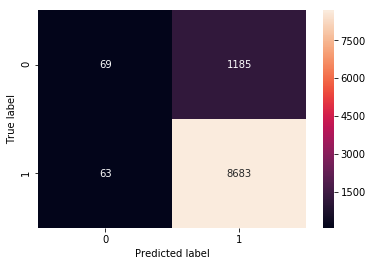

In [27]:
classifier = KNeighborsClassifier(n_neighbors=5, algorithm= 'brute')
fit_predict_performance_CM_CV(classifier,Bow_X_train, y_train, Bow_X_test, y_test)

K-fold cross validation score of model for k = 3 is :
88.34749798548475

Correct Classified Data Point:  8762

Correct % Classified Data Point:  87.62 %

====== Confusion matrix ======= 
[[  32 1222]
 [  16 8730]]
Confusion Matrix
    0     1
0  32  1222
1  16  8730


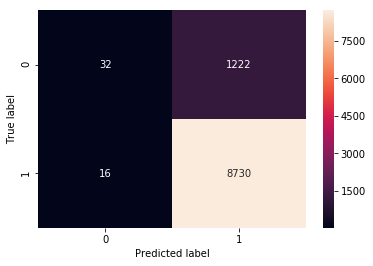

In [26]:
classifier = KNeighborsClassifier(n_neighbors=9, algorithm= 'brute')
fit_predict_performance_CM_CV(classifier,Bow_X_train, y_train, Bow_X_test, y_test)

**Most Frequent Words in Postive and Negative reviews**

In [201]:
freq_positive_dist=nltk.FreqDist(all_positive_words)
freq_negative_dist=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_positive_dist.most_common(10))
print("Most Common Negative Words : ",freq_negative_dist.most_common(10))

Most Common Positive Words :  [('like', 124538), ('tast', 115988), ('good', 100085), ('flavor', 96603), ('love', 96593), ('use', 93419), ('great', 92881), ('one', 87018), ('product', 82702), ('tri', 79105)]
Most Common Negative Words :  [('tast', 33462), ('like', 31239), ('product', 27149), ('one', 19931), ('flavor', 18845), ('would', 17374), ('tri', 17159), ('use', 14732), ('good', 14517), ('coffe', 14419)]


**========================================================================================================================++========**

**Observation on BoW KNN:**

1] As Most of the data as per review is imbalanced have 1 as Rated score.

2] After implementing KNN with different algorithms and GridSearch CV, we can observe that 5 and 9 came out to be optimal K value to implement KNN on given Bag of words where as Graph for error presented 9 as Better K for KNN which has more similar error to K = 11

3] KNN is working well compare to Test implementation that is almost approx to CV accuracy where,

CV Accuracy = 88.3%  With K(CV) = 3
Test Accuracy With K = 5 is 87.52 % Where K = 11 have 87.62% Accuracy that is not much of difference and It is better to Choose K = 5 for BoW 

So It seems that our Bow KNN is working good but as Train and test data accuracy have little variation that lead to over fitting of data as our data is Imbalanced.


As we can observe, Here on Confusion matrix 8762 points out of 10000 from test Data has been classified correctly but Most Data have been classified to Positive and still have 88% of accuracy that explains the variation on Imbalanced Data in our dataset sample and Model have biased.

**==========================================================================================================++======================**

# Tf-idf KNN

**Tfidf and finding Shape of data and Unique words in Dataframe**

In [28]:
tf_idf = TfidfVectorizer()
Tfidf_X_train = tf_idf.fit_transform(X_train)
Tfidf_X_test = tf_idf.transform(X_test)
print("Shape of BOW vectorizer: ",Tfidf_X_train.get_shape(), Tfidf_X_test.get_shape())
print("Number of unique words in 'Tfidf_X_train': ", Tfidf_X_train.get_shape()[1])
print("Number of unique words in 'Tfidf_X_test': ", Tfidf_X_test.get_shape()[1])

Shape of BOW vectorizer:  (40000, 24431) (10000, 24431)
Number of unique words in 'Tfidf_X_train':  24431
Number of unique words in 'Tfidf_X_test':  24431


**Calling classifier function with "Tfidf_X_train, y_train, Tfidf_X_test, y_test" for better K with Highest accuracy for Tfidf data**

In [132]:
best_K_train_test(Tfidf_X_train, y_train, Tfidf_X_test, y_test)

CV accuracy for k = 1 is 84%
CV accuracy for k = 3 is 87%
CV accuracy for k = 5 is 88%
CV accuracy for k = 7 is 88%
CV accuracy for k = 9 is 88%
CV accuracy for k = 11 is 88%


In [149]:
Grid_CV(Tfidf_X_train, y_train)

Grid Search CV Best 'K' Parameter
{'n_neighbors': 11}



The optimal number of neighbors is 11.


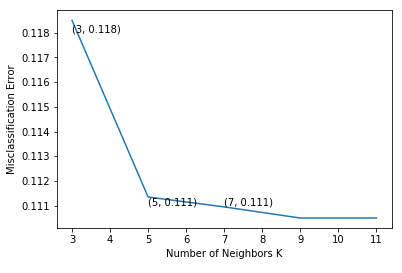

the misclassification error for each k value is :  [0.118 0.111 0.111 0.11  0.11 ]
CV Scores:  [0.8815000242262694, 0.8886500042357066, 0.8890500161109097, 0.8895000029868004, 0.8895000311110973]


In [144]:
crossval_error_plot(Tfidf_X_train, y_train)

**Calling CV function with "Tfidf_X_train, y_train" for Cross-Validation accuracy On Tfidf Vectorizer**

K-fold cross validation score of model for k = 3 is :
88.86500042357066

Correct Classified Data Point:  8826

Correct % Classified Data Point:  88.26 %

====== Confusion matrix ======= 
[[ 193 1066]
 [ 108 8633]]
Confusion Matrix
     0     1
0  193  1066
1  108  8633


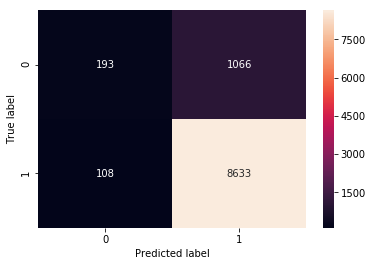

In [135]:
classifier = KNeighborsClassifier(n_neighbors=5, algorithm= 'brute')
fit_predict_performance_CM_CV(classifier, Tfidf_X_train, y_train, Tfidf_X_test, y_test)

K-fold cross validation score of model for k = 3 is :
88.92250279858315

Correct Classified Data Point:  8836

Correct % Classified Data Point:  88.36 %

====== Confusion matrix ======= 
[[ 139 1115]
 [  49 8697]]
Confusion Matrix
     0     1
0  139  1115
1   49  8697


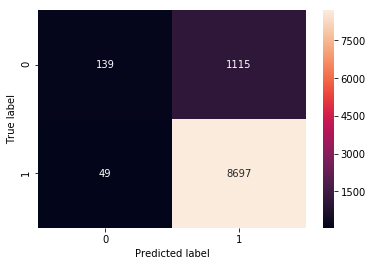

In [29]:
classifier = KNeighborsClassifier(n_neighbors=11, algorithm= 'brute')
fit_predict_performance_CM_CV(classifier, Tfidf_X_train, y_train, Tfidf_X_test, y_test)

**Top 5 Features in Tfidf**

In [199]:
features = tf_idf.get_feature_names()

In [200]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=5):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(tf_idf_matrix_train[1,:].toarray()[0],features,5)
top_tfidf

,feature,tfidf
0,oil,0.422411
1,coconut,0.362945
2,earthy,0.275932
3,nutiva,0.262925
4,warmer,0.246537


**==================================================================================================================================**

**TFiDf KNN Observation:**
    
1] After implenting with Tfidf, our classification seems to work better.

K with Running different model with different K, 5 with Error plot ans 11 with Grid SearchCv came out be Optimal K.

2] After implementing KNN with different algorithmson Tfidf we can observe that --5-- came out to be optimal K value to implement KNN on Tfidf with Highest Accuracy with CV, i.e: 88%

3] Model on Cross validation data have approx equal Accuracy to Test data that is 88%

3] KNN is working well compare to Test implementation that is almost approx to CV accuracy where,


CV Accuracy = 88.9%  With K(CV) = 3

Test Accuracy With K = 5 is 88.5 % Where K = 11 have 88.4% Accuracy that is not much of difference and It is better to Choose K = 11 for Tfidf as K = 11 have .10 more accuracy.

So It seems that our Tfidf KNN is working as approx same as Bow Model with give K and CV and test data accuracy have approx same.

As we can observe, Here on Confusion matrix 8836 points out of 10000 from test Data has been classified correctly but Most Data have been classified to Positive and still have 88% of accuracy that explains the variation on Imbalanced Data in our dataset sample and Model have biased but classification of Correct points are better than BoW model.


**==================================================================================================================================**

# Tfidf Word2Vec KNN

### Word2Vec

In [83]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in X_train[:]:
    list_of_sent.append(sent.split())

In [84]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent_test=[]
for sent in X_test[:]:
    list_of_sent_test.append(sent.split())

In [85]:
print(list_of_sent[0])

['fan', 'anna', 'cooki', 'year', 'ginger', 'long', 'favorit', 'saw', 'price', 'jump', 'fast', 'shipment', 'arriv', 'day', 'aw', 'slow', 'huge', 'compani', 'imo', 'cooki', 'appear', 'littl', 'case', 'howev', 'open', 'find', 'everi', 'box', 'twelv', 'contain', 'cooki', 'crumbl', 'one', 'singl', 'cooki', 'shipment', 'arriv', 'guess', 'crumbl', 'ice', 'cream', 'etc', 'definit', 'wed', 'want', 'return', 'well', 'see', 'amazon', 'handl']


In [86]:
# min_count = 10 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent, min_count= 10 ,size = 100, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 10 times ",len(w2v_words))
print("\nsample words:", w2v_words[0:50])

number of words that occured minimum 10 times  5863

sample words: ['fan', 'anna', 'cooki', 'year', 'ginger', 'long', 'favorit', 'saw', 'price', 'jump', 'fast', 'shipment', 'arriv', 'day', 'aw', 'slow', 'huge', 'compani', 'imo', 'appear', 'littl', 'case', 'howev', 'open', 'find', 'everi', 'box', 'twelv', 'contain', 'crumbl', 'one', 'singl', 'guess', 'ice', 'cream', 'etc', 'definit', 'wed', 'want', 'return', 'well', 'see', 'amazon', 'handl', 'good', 'weight', 'watcher', 'point', 'problem', 'eat']


In [87]:
w2v_model.wv['love']

array([ 0.7566558 ,  0.05582335, -0.21168014,  0.29660273, -0.13402812,
       -0.1571906 ,  0.81666124, -2.0157785 , -0.14808565, -0.05638735,
       -1.8169278 ,  0.5139286 ,  0.22739509,  1.6457512 ,  0.56044245,
        0.74311817, -0.17936611, -2.1267653 ,  0.29080933, -0.44769543,
        0.70414215,  0.8826104 ,  0.43633258,  0.7596565 ,  0.65430856,
       -0.13248336, -0.5315567 , -0.637664  ,  0.00996353,  1.1952977 ,
       -1.0876347 ,  1.0698818 ,  0.39878088,  0.8407998 ,  0.27489617,
       -0.45795345, -0.811475  ,  0.24599382,  0.9110746 , -0.21112412,
       -0.21914724, -1.4238362 , -0.3610667 , -0.7220125 , -0.84148467,
        1.2702057 ,  1.7386872 ,  0.19145446, -0.01335275, -0.23065695,
        0.68400985,  0.98779875,  1.6172587 ,  0.1966966 , -0.69406253,
       -0.95485705,  0.17740451, -0.90640235,  1.4001609 ,  0.53247476,
       -0.8613349 ,  0.29762223, -0.67811143,  0.70464134, -0.3809917 ,
        0.57945013,  0.06945298, -0.26778647, -0.8605135 , -1.48

**With a dataset this large, its difficult to make an easy-to-read TSNE visualization. So we can use the model to look up the most similar words from any given point.**

In [88]:
w2v_model.most_similar('food')

[('feed', 0.5551376342773438),
 ('pet', 0.5261924266815186),
 ('evo', 0.5261885523796082),
 ('innova', 0.5057865977287292),
 ('grain', 0.49293792247772217),
 ('anim', 0.49089953303337097),
 ('newman', 0.4905160069465637),
 ('nutro', 0.4878898859024048),
 ('evolut', 0.4782896637916565),
 ('finicki', 0.474841833114624)]

In [89]:
w2v_model.most_similar('buy')

[('purchas', 0.7935301065444946),
 ('sell', 0.6783775687217712),
 ('order', 0.6632588505744934),
 ('pay', 0.6117270588874817),
 ('sold', 0.5956789255142212),
 ('stock', 0.5766605138778687),
 ('bought', 0.5636247396469116),
 ('save', 0.5580421686172485),
 ('reorder', 0.5364304780960083),
 ('carri', 0.5224781632423401)]

## Tfidf W2V KNN

**Creating Tfidf for Word 2 Vector, Creating dictionary with each word as key and values as its vector and computed tfidf.**

In [90]:
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(X_train)
tf_idf_matrix_test = model.transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

**Creating Vector of Train data using W2V Model**

In [91]:
tfidf_feat = model.get_feature_names()
# average Word2Vec
# compute average word2vec for each review in train data

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            Tf_idf_w2v_train = dictionary[word]*sent.count(word)
            #Tf_idf_w2v_train = Tfidf_X_train[row, tf_idf.get_feature_names().index(word)]
            sent_vec += (vec * Tf_idf_w2v_train)
            weight_sum += Tf_idf_w2v_train
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

**Creating Vector of Train data using W2V Model**

In [92]:
# average Word2Vec
# compute average word2vec for each review in test data

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            Tf_idf_w2v_test = dictionary[word]*sent.count(word)
            sent_vec += (vec * Tf_idf_w2v_test)
            weight_sum += Tf_idf_w2v_test
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

**W2V vectorizer Matrix for further analysis**

In [93]:
tfidfw2v_train = tfidf_sent_vectors_train
tfidfw2v_test = tfidf_sent_vectors_test

**Calling classifier function with "tfidfw2v_train, y_train, tfidfw2v_test, y_test" for better K with Highest accuracy for W2V tfidf**

In [138]:
best_K_train_test(tfidfw2v_train, y_train, tfidfw2v_test, y_test)

CV accuracy for k = 1 is 83%
CV accuracy for k = 3 is 86%
CV accuracy for k = 5 is 87%
CV accuracy for k = 7 is 88%
CV accuracy for k = 9 is 88%
CV accuracy for k = 11 is 88%


In [139]:
Grid_CV(tfidfw2v_train, y_train)

Grid Search CV Best 'K' Parameter
{'n_neighbors': 11}



The optimal number of neighbors is 11.


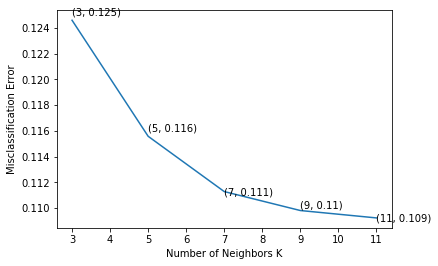

the misclassification error for each k value is :  [0.125 0.116 0.111 0.11  0.109]
CV Scores:  [0.8754000460930977, 0.8844250261048786, 0.8887249779864567, 0.8901999698635034, 0.8907749711141908]


In [145]:
crossval_error_plot(tfidfw2v_train, y_train)

K-fold cross validation score of model for k = 3 is :
88.87249779864567

Correct Classified Data Point:  8821

Correct % Classified Data Point:  88.21 %

====== Confusion matrix ======= 
[[ 239 1020]
 [ 159 8582]]
Confusion Matrix
     0     1
0  239  1020
1  159  8582


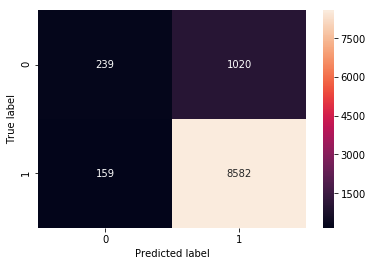

In [140]:
classifier = KNeighborsClassifier(n_neighbors=7, algorithm= 'brute')
fit_predict_performance_CM_CV(classifier, tfidfw2v_train, y_train, tfidfw2v_test, y_test)

K-fold cross validation score of model for k = 3 is :
89.07749711141908

Correct Classified Data Point:  8844

Correct % Classified Data Point:  88.44 %

====== Confusion matrix ======= 
[[ 209 1050]
 [ 106 8635]]
Confusion Matrix
     0     1
0  209  1050
1  106  8635


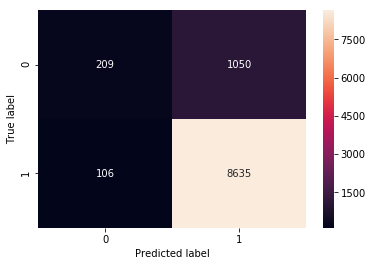

In [141]:
classifier = KNeighborsClassifier(n_neighbors=11, algorithm= 'brute')
fit_predict_performance_CM_CV(classifier, tfidfw2v_train, y_train, tfidfw2v_test, y_test)

**==================================================================================================================================**

**TFiDf-W2V KNN Observation:**
    
1] After Computing W2V for train and test data on Tfidf with Size = 100 where Threshold for word to be in Review is 10.

K with Running different model with different K, 7 with Error plot wof CV and 11 with Grid SearchCv came out be Optimal K.

2] After implementing KNN with different algorithms on TfidfW2V we can observe that 11 turn out to be optimal K value to implement KNN on Tfidf with Avg W2V using GridSearchCV.

3] KNN is working well compare to Test implementation than CV accuracy where,

CV Accuracy = 89% With K(CV) = 3

Test Accuracy With K = 7 is 88.21 % Where K = 11 have 88.4% Accuracy that is not much of difference between K and It is better to Choose K = 11 for Tfidf as K = 11 have .20 more accuracy.

As we can observe, Here on Confusion matrix 8844 points out of 10000 from test Data has been classified correctly but Most Data have been classified to Positive and still have 88.44% of accuracy that explains the variation on Imbalanced Data in our dataset sample and Model have biased but classification of Correct points are better than BoW/Tfidf model.

**==================================================================================================================================**